# ex057
2 output model


In [96]:
import gc
import os
import random
import time
import math

import cv2
import numpy as np
import matplotlib.pyplot as plt

# model
import torch
import torchvision
import torch.nn as nn
import timm
from torchvision.models.feature_extraction import create_feature_extractor
import torchvision.transforms.functional as TF

# data loader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset

# training
from torch.optim import SGD, Adam, AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau, ExponentialLR, CyclicLR

# metric
from sklearn.metrics import fbeta_score, roc_auc_score

import wandb

import warnings
warnings.filterwarnings('ignore')

In [97]:
import yaml
exp_name = "exp057"
config_path = os.path.join("/working","output", exp_name, "Config.yaml")
with open(config_path, "r") as f:
    CFG = yaml.safe_load(f)
CFG["OUTPUT_DIR"] = os.path.join("/working","output", exp_name)
print(CFG)

CFG["slide_pos_list"] = [[0,0]]

{'EXP_CATEGORY': 'SUBCLASS', 'INPUT_DIR': '/working/input/vesuvius-challenge-ink-detection', 'RANDOM_SLIDE': True, 'TRAIN_DIR': '/working/input/vesuvius-challenge-ink-detection/train', 'TRAIN_DIR_LIST': [['1', '2_0', '2_1', '2_2'], ['1', '2_0', '2_1', '3'], ['1', '2_0', '2_2', '3'], ['1', '2_1', '2_2', '3'], ['2_0', '2_1', '2_2', '3']], 'T_max': 5, 'VALID_DIR_LIST': [['3'], ['2_2'], ['2_1'], ['2_0'], ['1']], 'base_lr': 0.0001, 'batch_size': 8, 'folds': [0, 1, 2, 3, 4], 'img_size': [512, 512], 'inp_channels': 4, 'lr': 0.0001, 'max_lr': 0.0005, 'min_lr': 1e-08, 'model_name': 'tf_efficientnet_b6', 'channel_nums': [576, 200, 72, 40, 32], 'n_epoch': 15, 'num_workers': 2, 'out_channels': 1, 'out_indices': [0, 1, 2, 3, 4], 'pretrained': True, 'print_freq': 1000, 'random_seed': 21, 'slide_pos_list': [[0, 0], [256, 0], [0, 256], [256, 256]], 'step_size_down': 10, 'step_size_up': 5, 'SURFACE_LIST': [[26, 29, 32, 35], [27, 30, 33, 36], [25, 28, 31, 34]], 'surface_num': 4, 'weight_decay': 1e-06, '

# config

In [98]:
def seed_everything(seed=CFG["random_seed"]):
    #os.environ['PYTHONSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic =True
    torch.backends.cudnn.benchmark = False
seed_everything()

# device optimization
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'Using device: {device}')

Using device: cuda


In [99]:
def asMinutes(s):
    """Convert Seconds to Minutes."""
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    """Accessing and Converting Time Data."""
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

class AverageMeter(object):
    """Computes and stores the average and current value."""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# metric

In [100]:
def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta_auc(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    dice_list = [] 
    # for th in np.array(range(10, 50+1, 5)) / 100:
    for th in np.array(range(10, 100+1, 5)) / 100:
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice_list.append(dice)
        print(f'\t th: {th}, fbeta: {dice}')
        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    auc = roc_auc_score(mask, mask_pred)
    # Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th, auc, dice_list


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th, auc, dice_list = calc_fbeta_auc(mask_gt, mask_pred)

    return best_dice, best_th, auc, dice_list

# model

In [101]:
class Encoder(nn.Module):
    def __init__(self, CFG):
        super().__init__()
        self.encoder = timm.create_model(CFG["model_name"], in_chans=CFG["inp_channels"], 
                                         features_only=True, out_indices=CFG["out_indices"], pretrained=CFG["pretrained"])
    def forward(self, img):
        skip_connection_list = self.encoder(img)
        return skip_connection_list

class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size = 2, padding="same")
        self.bn2 = nn.BatchNorm2d(out_channels)
    def forward(self, x):
        x = self.up(x)
        x = self.bn1(x)
        x = self.conv(x)
        x = self.bn2(x)
        return x
    
class Decoder(nn.Module):
    def __init__(self, CFG):
        super().__init__()
        self.UpConv_0 = UpConv(CFG["channel_nums"][0], CFG["channel_nums"][1])
        self.UpConv_1 = UpConv(CFG["channel_nums"][1]*2, CFG["channel_nums"][2])
        self.UpConv_2 = UpConv(CFG["channel_nums"][2]*2, CFG["channel_nums"][3])
        self.UpConv_3 = UpConv(CFG["channel_nums"][3]*2, CFG["channel_nums"][4])
    def forward(self, skip_connection_list):
        emb = self.UpConv_0(skip_connection_list[4]) # emb.shape = (None, 160, 14, 14)
        emb_cat = torch.cat([skip_connection_list[3], emb], dim = 1)
        emb = self.UpConv_1(emb_cat)
        emb_cat = torch.cat([skip_connection_list[2], emb], dim = 1)
        emb = self.UpConv_2(emb_cat)
        emb_cat = torch.cat([skip_connection_list[1], emb], dim = 1)
        emb = self.UpConv_3(emb_cat)
        emb_cat = torch.cat([skip_connection_list[0], emb], dim = 1)
        return emb_cat

class SegModel(nn.Module):
    def __init__(self, CFG):
        super().__init__()
        self.encoder = Encoder(CFG)
        self.decoder = Decoder(CFG)
        self.GAP = nn.AdaptiveAvgPool2d(output_size=(1))
        self.classifier = nn.Sequential(
            nn.Linear(CFG["channel_nums"][0], 1),
            nn.Sigmoid()
        )
        self.head = nn.Sequential(
            nn.Conv2d(CFG["channel_nums"][-1]*2, CFG["out_channels"], kernel_size=1, stride=1, padding=0),
        )
    def forward(self, img):
        skip_connection_list = self.encoder(img)
        output_class = self.GAP(skip_connection_list[-1])
        output_class = output_class.view(-1, CFG["channel_nums"][0])
        output_class = self.classifier(output_class)
        emb = self.decoder(skip_connection_list)
        output_mask = self.head(emb)

        return output_class, output_mask



# Dataset

In [102]:
train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomCrop(int(CFG["img_size"][0]*0.8), int(CFG["img_size"][1]*0.8), p=0.3),
    A.Blur(blur_limit=3, p=0.3),
    A.Resize(CFG["img_size"][0], CFG["img_size"][1]),
    ToTensorV2(),
])

valid_transforms = A.Compose([
    ToTensorV2(),
])

In [103]:
class VCID_Dataset(Dataset):
    def __init__(self, CFG, data_dir_list, surface_list, surface_volumes=None, slide_pos=[0,0], mode="train", transform=None):
        # get config
        self.mode = mode
        self.RANDOM_SLIDE = CFG["RANDOM_SLIDE"]
        self.img_size = CFG["img_size"]
        if self.mode=="train":  self.DATADIR = CFG["TRAIN_DIR"]
        elif self.mode=="valid":    self.DATADIR = CFG["TRAIN_DIR"]
        elif self.mode == "test":   self.DATADIR = CFG["TEST_DIR"]
        self.data_dir_list = data_dir_list
        self.surface_list = surface_list
        self.slide_pos = slide_pos
        self.transform = transform
        
        # get imgs
        # print("initializing dataset...")
        self.imgs = []
        for data_dir in self.data_dir_list:
            img_path = os.path.join(self.DATADIR, data_dir, "mask.png")
            # print(img_path)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = img.reshape(img.shape[0], img.shape[1], 1) # (h, w, channel=1)
            assert img is not None, "img is None. data path is wrong"
            self.imgs.append(img)  
        
        # get and split surface
        if surface_volumes is None:
            self.surface_vols = self.read_surfacevols()
        else:
            # print("using loaded surface_vols")
            self.surface_vols = surface_volumes
       
        # split grid
        self.get_all_grid()
        self.fileter_grid()
        self.get_flatten_grid()
        # print("split grid done.") 
       
        # get label imgs
        if self.mode == "train" or self.mode == "valid":
            self.labels = []
            for data_dir in self.data_dir_list:
                label_path = os.path.join(self.DATADIR, data_dir, "inklabels.png")
                assert os.path.exists(label_path), f"{label_path} is not exist."
                # read label
                label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
                label = label.reshape(label.shape[0], label.shape[1], 1) # (h, w, channel=1)
                self.labels.append(label)# 画像サイズがそれぞれ違うので単純にconcatできずlist化しているs
        # print("initializing dataset done.")

    def get_surface_volumes(self):
        return self.surface_vols

    def read_surfacevols(self):
        """ read surface volume by data_dir_list and surface_list 
            Returns:surface_vuls (list): surface volume list [array(h,w,channel=surface_num), array(), ...]
        """
        surface_vols = []
        # print("reading surface volume...")
        for data_dir in self.data_dir_list:
            surface_vol_ = None
            for read_idx, surface_idx in enumerate(self.surface_list):
                # print("\r", f"reading idx : {read_idx+1}/{len(self.surface_list)}", end="")
                surface_path = os.path.join(self.DATADIR, data_dir, "surface_volume", f"{surface_idx:02}.tif")
                surface_vol = cv2.imread(surface_path, cv2.IMREAD_GRAYSCALE)
                surface_vol = surface_vol.reshape(surface_vol.shape[0], surface_vol.shape[1], 1) # (h, w, channel=1)
                if surface_vol_ is None:
                    surface_vol_ = surface_vol
                else:
                    surface_vol_ = np.concatenate([surface_vol_, surface_vol], axis=2) # (h, w, channel=surface_num)
            surface_vols.append(surface_vol_)
            # print(f"  => read surface volume done. [{data_dir}]")
        return surface_vols


    def get_grid_img(self, img, grid_idx):
        """ crop grid img from original img"""
        img_grid = img[(grid_idx[0]*self.img_size[0]) + self.slide_pos[0] : ((grid_idx[0]+1)*self.img_size[0]) + self.slide_pos[0],
                        (grid_idx[1]*self.img_size[1]) + self.slide_pos[1] : ((grid_idx[1]+1)*self.img_size[1]) + self.slide_pos[1]]
        return img_grid
    
    def get_grid_img_and_mask(self, img, mask, grid_idx):
        """ crop grid img from original img"""
        if self.RANDOM_SLIDE and self.mode=="train" and random.random() < 0.5:
            if (grid_idx[0]!=0 and grid_idx[1]!=0) and (grid_idx[0]!=img.shape[0]//self.img_size[0] and grid_idx[1]!=img.shape[1]//self.img_size[1]):
                rand_pos = [np.random.randint(0, self.img_size[0]//4) - self.img_size[0]//4, np.random.randint(0, self.img_size[1]//4)-self.img_size[1]//4]
            else:
                rand_pos = [0, 0]
        else:
            rand_pos = [0, 0]
        self.rand_pos = rand_pos
        img_grid = img[(grid_idx[0]*self.img_size[0]) + self.slide_pos[0] + rand_pos[0] : ((grid_idx[0]+1)*self.img_size[0]) + self.slide_pos[0] + rand_pos[0],
                        (grid_idx[1]*self.img_size[1]) + self.slide_pos[1] + rand_pos[1] : ((grid_idx[1]+1)*self.img_size[1]) + self.slide_pos[1] + rand_pos[1]]
        mask_grid = mask[(grid_idx[0]*self.img_size[0]) + self.slide_pos[0] + rand_pos[0] : ((grid_idx[0]+1)*self.img_size[0]) + self.slide_pos[0] + rand_pos[0],
                         (grid_idx[1]*self.img_size[1]) + self.slide_pos[1] + rand_pos[1] : ((grid_idx[1]+1)*self.img_size[1]) + self.slide_pos[1] + rand_pos[1]]
        return img_grid/255., mask_grid/255.
    
    def get_masked_img(self, img, mask):
        """ multiply mask to surface_volumes """
        masked_img = None
        for channel in range(img.shape[2]):
            img_channel = img[:,:,channel].reshape(img.shape[0], img.shape[1],1)
            masked = img_channel*mask
            if masked_img is None:
                masked_img = masked.reshape(masked.shape[0], masked.shape[1], 1)
            else:
                masked = masked.reshape(masked.shape[0], masked.shape[1], 1)
                masked_img = np.concatenate([masked_img, masked], axis=2)
        return masked_img
    
    
    def get_all_grid(self):
        """ get all grid indices by img size and grid size
        """
        self.grid_indices = []
        for img in self.imgs:
            self.x_grid_size = (img.shape[0] - self.slide_pos[0]) // self.img_size[0]
            self.y_grid_size = (img.shape[1] - self.slide_pos[1]) // self.img_size[1]
            grid_img = []
            for i in range(self.x_grid_size):
                for j in range(self.y_grid_size):
                    grid_img.append([i, j])
            self.grid_indices.append(grid_img)
        return self.grid_indices
          
    def fileter_grid(self):
        """ get grid indices which mask is not 0 by all grid indices"""
        grid_indices_all = []
        for img, grid_indices in zip(self.imgs, self.grid_indices):
            grid_indices_copy = grid_indices.copy()
            for grid_idx in grid_indices:
                img_grid = self.get_grid_img(img, grid_idx)
                if img_grid.sum() == 0:
                    grid_indices_copy.remove(grid_idx)
            grid_indices_all.append(grid_indices_copy)
        self.grid_indices = grid_indices_all
        return self.grid_indices

    def get_flatten_grid(self):
        """ get flatten index list by grid indices
            Returns:flatten_grid (list): flatten index list [[img_idx, grid_idx], [img_idx, grid_idx], ...]
        """
        flatten_grid = []
        for img_idx, grid_indices in enumerate(self.grid_indices):
            for grid_idx in grid_indices:
                grid_imgidx_list = [img_idx]
                grid_imgidx_list.extend(grid_idx)
                flatten_grid.append(grid_imgidx_list)
        self.flatten_grid = flatten_grid
        return self.flatten_grid
    
    def channel_shuffle(self, img):
        img = img.transpose(2, 0, 1)
        np.random.shuffle(img)
        return img.transpose(1, 2, 0)

    def __len__(self):
        return len(self.flatten_grid)

    def __getitem__(self, idx):
        # get indices
        img_grid_idx = self.flatten_grid[idx]
        img_idx = img_grid_idx[0]
        grid_idx = img_grid_idx[1:]
        # get img & surface_vol
        mask = self.imgs[img_idx]
        surface_vol = self.surface_vols[img_idx]
        # mask = self.get_grid_img(mask, grid_idx)/255.
        # surface_vol = self.get_grid_img(surface_vol, grid_idx)/255.
        mask, surface_vol = self.get_grid_img_and_mask(mask, surface_vol, grid_idx)
        # multiple small mask 
        assert surface_vol.shape[0]==mask.shape[0] and surface_vol.shape[1]==mask.shape[1] , "surface_vol_list shape is not same as img shape"
        img = surface_vol
        # transform
        if self.mode == "test":
            if self.transform:
                img = self.transform(image=img)["image"]
            else:
                img = img.transpose(2, 0, 1)
                img = torch.tensor(img, dtype=torch.float32)
            return img, grid_idx
        elif self.mode == "train" or self.mode=="valid":
            # get label(segmentation mask)
            label = self.labels[img_idx]
            label = self.get_grid_img(label, grid_idx)
            label_class = (np.sum(label) > 0).astype(np.int32)
            # if self.mode == "train":
            #     img = self.channel_shuffle(img)
            if self.transform:
                transformed = self.transform(image=img, mask=label)
                img = transformed["image"]
                label = transformed["mask"]
                label = label.permute(2, 0, 1)/255. # (channel, h, w)
                # label = TF.resize(img=label, size=(self.img_size[0]//2, self.img_size[1]//2))
            else:
                img = img.transpose(2, 0, 1) # (channel, h, w)
                label = label.transpose(2, 0, 1)/255. # (channel, h, w){}
                img = torch.tensor(img, dtype=torch.float32)
                label = torch.tensor(label, dtype=torch.float32)
                # label = TF.resize(img=label, size=(self.img_size[0]//2, self.img_size[1]//2))
            label_class = torch.tensor(label_class, dtype=torch.float32)
            assert img is not None and label is not None, f"img or label is None {img} {label}, {img_idx}, {grid_idx}, {self.rand_pos}"
            return img, label, label_class,grid_idx


In [104]:
# valid_dirs = CFG["VALID_DIR_LIST"][0]
# surface_list = SURFACE_LIST[0]
# print("dataset")
# dataset_notrans = VCID_Dataset(CFG, valid_dirs, surface_list, mode="train")
# surface_volumes = dataset_notrans.surface_vols
# print("dataloader")
# dataloader_notrans = DataLoader(dataset_notrans, 4, shuffle=False, num_workers=0)

# imshow_batch = 10

# for batch_idx, (imgs, labels, grid_idx) in enumerate(dataloader_notrans):
#     img = imgs[0].permute(1, 2, 0)
#     if batch_idx < 2:
#         plt.figure(figsize=(20,5))
#         for channel in range(img.shape[2]):
#             plt.subplot(1, img.shape[2], channel+1)
#             plt.imshow(img[:,:,channel], cmap="gray")
#         plt.show()
#         [print(np.max(img[:,:,idx].numpy())) for idx in range(img.shape[2])]
        
#     if batch_idx >= imshow_batch:
#         break    

# img_hist, img_bins = np.histogram(np.array(img[:,:,0]).flatten())
# plt.figure()
# plt.plot(img_hist)
# plt.show()
# print(img[:,:,0])


In [105]:
# valid_dirs = CFG["VALID_DIR_LIST"][0]
# surface_list = SURFACE_LIST[0]
# print("dataset")
# dataset_notrans = VCID_Dataset(CFG, valid_dirs, surface_list, mode="train")
# surface_volumes = dataset_notrans.surface_vols
# print("dataloader")
# dataloader_notrans = DataLoader(dataset_notrans, 4, shuffle=False, num_workers=0)

# imshow_batch = 10

# for batch_idx, (imgs, labels, grid_idx) in enumerate(dataloader_notrans):
#     img = imgs[0].permute(1, 2, 0)
#     if batch_idx < 2:
#         plt.figure(figsize=(20,5))
#         for channel in range(img.shape[2]):
#             plt.subplot(1, img.shape[2], channel+1)
#             plt.imshow(img[:,:,channel], cmap="gray")
#         plt.show()
#         [print(np.max(img[:,:,idx].numpy())) for idx in range(img.shape[2])]
#     if batch_idx >= imshow_batch:
#         break    

# img_hist, img_bins = np.histogram(np.array(img[:,:,0]).flatten())
# plt.figure()
# plt.plot(img_hist)
# plt.show()
# print(img[:,:,0])


In [106]:
# print("dataset")
# dataset_notrans = VCID_Dataset(CFG, valid_dirs, surface_list, surface_volumes, slide_pos=[0,50],mode="train")
# print("dataloader")
# dataloader_notrans = DataLoader(dataset_notrans, 4, shuffle=False, num_workers=0)

# imshow_batch = 10

# for batch_idx, (imgs, labels, grid_idx) in enumerate(dataloader_notrans):
#     img = imgs[0].permute(1, 2, 0)
#     if batch_idx == 1:
#         plt.figure(figsize=(20,5))
#         for channel in range(img.shape[2]):
#             plt.subplot(1, img.shape[2], channel+1)
#             plt.imshow(img[:,:,channel], cmap="gray")
#         plt.show()
#         [print(np.max(img[:,:,idx].numpy())) for idx in range(img.shape[2])]
#     if batch_idx >= imshow_batch:
#         break    

# img_hist, img_bins = np.histogram(np.array(img[:,:,0]).flatten())
# plt.figure()
# plt.plot(img_hist)
# plt.show()
# print(img[:,:,0])


In [107]:
# valid_dirs = CFG["VALID_DIR_LIST"][0]
# surface_list = SURFACE_LIST[0]
# print("dataset")
# dataset_notrans = VCID_Dataset(CFG, valid_dirs, surface_list, mode="train", transform=train_transforms)
# print("dataloader")
# dataloader_notrans = DataLoader(dataset_notrans, 4, shuffle=False, num_workers=0)


# imshow_batch = 10

# for batch_idx, (imgs, labels, grid_idx) in enumerate(dataloader_notrans):
#     img = imgs[0].permute(1, 2, 0)
#     if batch_idx == 0:
#         plt.figure(figsize=(20,5))
#         for channel in range(img.shape[2]):
#             plt.subplot(1, img.shape[2], channel+1)
#             plt.imshow(img[:,:,channel], cmap="gray")
#         plt.show()
#         [print(np.max(img[:,:,idx].numpy())) for idx in range(img.shape[2])]
#     if batch_idx >= imshow_batch:
#         break    

# img_hist, img_bins = np.histogram(np.array(img[:,:,0]).flatten())
# plt.figure()
# plt.plot(img_hist)
# plt.show()
# print(img[:,:,0])

# Loss

In [108]:
#PyTorch
ALPHA = 0.1 # < 0.5 penalises FP more, > 0.5 penalises FN more
CE_RATIO = 0.90 #weighted contribution of modified CE loss compared to Dice loss

class ComboLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(ComboLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, alpha=ALPHA, eps=1e-9):
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #True Positives, False Positives & False Negatives
        intersection = (inputs * targets).sum()    
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        
        inputs = torch.clamp(inputs, eps, 1.0 - eps)       
        out = - (ALPHA * ((targets * torch.log(inputs)) + ((1 - ALPHA) * (1.0 - targets) * torch.log(1.0 - inputs))))
        weighted_ce = out.mean(-1)
        # if dice is None or dice > 0:
        #     combo = weighted_ce
        # else:
        #     combo = (CE_RATIO * weighted_ce) - ((1 - CE_RATIO) * dice)
        combo = (CE_RATIO * weighted_ce) - ((1 - CE_RATIO) * dice)
        assert combo is not None, f"combo loss is None, weighted_ce: {weighted_ce}, dice: {dice}"
        return combo

# train valid fn

In [109]:
def valid_fn(model, valid_loader, criterion=None):
    model.eval()# モデルを検証モードに設定
    test_targets_mask, test_preds_mask = [], []
    test_targets_class, test_preds_class = [], []
    test_grid_idx = []
    batch_time = AverageMeter()
    losses = AverageMeter()
    start = end = time.time()
    for batch_idx, (images, targets_mask, targets_class, grid_idx) in enumerate(valid_loader):
        images = images.to(device, non_blocking = True).float()
        targets_mask = targets_mask.to(device, non_blocking = True).float()
        targets_class = targets_class.to(device, non_blocking = True).float().view(-1, 1)
        with torch.no_grad():
            preds_class, preds_mask = model(images)
            preds_mask = TF.resize(img=preds_mask, size=(CFG["img_size"][0], CFG["img_size"][1]))
            assert preds_mask is not None, f"preds_mask is None, {preds_mask}, {images}, {targets_mask}"
            assert preds_class is not None, f"preds_class is None, {preds_class}, {images}, {targets_class}"
            if not criterion is None:
                loss = criterion(preds_class, targets_class, preds_mask, targets_mask)
                assert loss is not None, f"loss is None, {loss}, {images}, {targets_mask}, {targets_class}"
            preds_mask = torch.sigmoid(preds_mask)
        if not criterion is None:
            losses.update(loss.item(), CFG["batch_size"])
        batch_time.update(time.time() - end)

        targets_mask = targets_mask.detach().cpu().numpy()
        preds_mask = preds_mask.detach().cpu().numpy()
        targets_class = targets_class.detach().cpu().numpy().ravel().tolist()
        preds_class = preds_class.detach().cpu().numpy().ravel().tolist()
        
        test_preds_mask.extend([preds_mask[idx, :,:,:].transpose(1,2,0) for idx in range(preds_mask.shape[0])])
        test_targets_mask.extend([targets_mask[idx, :,:,:].transpose(1,2,0) for idx in range(targets_mask.shape[0])])
        test_preds_class.extend(preds_class)
        test_targets_class.extend(targets_class)
        
        test_grid_idx.extend([[x_idx, y_idx] for x_idx, y_idx in zip(grid_idx[0].tolist(), grid_idx[1].tolist())])

        if (batch_idx % CFG["print_freq"] == 0 or batch_idx == (len(valid_loader)-1)) and (not criterion is None):
            LOGGER.info('EVAL: [{0}/{1}] '
                'Elapsed {remain:s} '
                'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                .format(
                    batch_idx, len(valid_loader), batch_time=batch_time, loss=losses,
                    remain=timeSince(start, float(batch_idx+1)/len(valid_loader)),
                ))
        del images, preds_class, preds_mask, targets_mask, targets_class
        gc.collect()
        torch.cuda.empty_cache()
    if criterion is None:
        return test_targets_mask, test_preds_mask, test_targets_class, test_preds_class, test_grid_idx
    else:
        return test_targets_mask, test_preds_mask, test_targets_class, test_preds_class, test_grid_idx, losses.avg



In [110]:
def concat_grid_img(img_list, label_list, grid_idx_list, valid_dir_list, slide_pos=[0,0]):
    # concat pred img and label to original size
    img_path = os.path.join(CFG["TRAIN_DIR"], valid_dir_list[0], "mask.png")
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = img.reshape(img.shape[0], img.shape[1], 1)
    pred_img = np.zeros_like(img).astype(np.float32)
    label_img = np.zeros_like(img).astype(np.float32)
    for img_idx, grid_idx in enumerate(grid_idx_list):
        pred_img[grid_idx[0]*CFG["img_size"][0]+slide_pos[0] : (grid_idx[0]+1)*CFG["img_size"][0]+slide_pos[0],
                grid_idx[1]*CFG["img_size"][1]+slide_pos[1] : (grid_idx[1]+1)*CFG["img_size"][1]+slide_pos[1], :] += img_list[img_idx]
        
        label_img[grid_idx[0]*CFG["img_size"][0]+slide_pos[0] : (grid_idx[0]+1)*CFG["img_size"][0]+slide_pos[0],
                grid_idx[1]*CFG["img_size"][1]+slide_pos[1] : (grid_idx[1]+1)*CFG["img_size"][1]+slide_pos[1], :] += label_list[img_idx]
    return pred_img, label_img

In [111]:
def concat_grid_img_withclass(img_list, class_list, label_list, grid_idx_list, valid_dir_list, CFG, class_thr=0.1, slide_pos=[0,0], show_img=False):
    # concat pred img and label to original size
    img_path = os.path.join(CFG["TRAIN_DIR"], valid_dir_list[0], "mask.png")
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = img.reshape(img.shape[0], img.shape[1], 1)
    pred_img = np.zeros_like(img).astype(np.float32)
    label_img = np.zeros_like(img).astype(np.float32)
    for img_idx, grid_idx in enumerate(grid_idx_list):
        class_pred = class_list[img_idx]
        if class_pred >= class_thr:
            pred_img[grid_idx[0]*CFG["img_size"][0]+slide_pos[0] : (grid_idx[0]+1)*CFG["img_size"][0]+slide_pos[0],
                     grid_idx[1]*CFG["img_size"][1]+slide_pos[1] : (grid_idx[1]+1)*CFG["img_size"][1]+slide_pos[1], :] += img_list[img_idx]
        
        label_img[grid_idx[0]*CFG["img_size"][0]+slide_pos[0] : (grid_idx[0]+1)*CFG["img_size"][0]+slide_pos[0],
                grid_idx[1]*CFG["img_size"][1]+slide_pos[1] : (grid_idx[1]+1)*CFG["img_size"][1]+slide_pos[1], :] += label_list[img_idx]
        
        if class_pred < class_thr and show_img:
            plt.figure(dpi=30)
            plt.subplot(1,2,1)
            plt.imshow(img_list[img_idx])
            plt.subplot(1,2,2)
            plt.imshow(label_list[img_idx])
            plt.show()
    return pred_img, label_img

In [112]:
def save_and_plot_oof(mode, fold, slice_idx, valid_preds_img, valid_targets_img, valid_preds_binary, CFG):
    cv2.imwrite(os.path.join(CFG["OUTPUT_DIR"], "imgs", f"fold{fold}_{mode}_slice{slice_idx}_valid_pred_img.png"), valid_preds_img*255)
    cv2.imwrite(os.path.join(CFG["OUTPUT_DIR"], "imgs", f"fold{fold}_{mode}_slice{slice_idx}_valid_predbin_img.png"), valid_preds_binary*255)
    cv2.imwrite(os.path.join(CFG["OUTPUT_DIR"], "imgs", f"fold{fold}_{mode}_slice{slice_idx}_valid_targets_img.png"), valid_targets_img*255)
    
    # plot preds & binary preds
    plt.figure(dpi=100)
    plt.subplot(1,3,1)
    plt.imshow(valid_preds_img)
    plt.subplot(1,3,2)
    plt.imshow(valid_preds_binary)
    plt.subplot(1,3,3)
    plt.imshow(valid_targets_img)
    plt.show()
                

# slice inference

In [115]:
def slide_inference(CFG):
    start_time = time.time()
    slice_ave_score_list, slice_ave_auc_list, slice_ave_score_threshold_list = [], [], []
    for fold in CFG["folds"]:
        print(f"-- fold{fold} slide inference start --")
 
        # set model & learning fn
        model = SegModel(CFG)
        # model_path = os.path.join(CFG["OUTPUT_DIR"], f'{CFG["model_name"]}_fold{fold}.pth')
        model_path = os.path.join(CFG["OUTPUT_DIR"], f'{CFG["model_name"]}_auc_fold{fold}.pth')
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)
        valid_img_slice = None
        for slice_idx, surface_list in enumerate(CFG["SURFACE_LIST"]):
            print(f"surface_list: {surface_list}")
            surface_volumes = None
            for slide_pos in CFG["slide_pos_list"]:
                print(f"slide pos:{slide_pos}")
                valid_dirs = CFG["VALID_DIR_LIST"][fold]
                valid_dataset = VCID_Dataset(CFG, valid_dirs, surface_list, surface_volumes, slide_pos, mode="valid", transform=valid_transforms)
                surface_volumes = valid_dataset.get_surface_volumes()
                valid_loader = DataLoader(valid_dataset, batch_size=CFG["batch_size"], shuffle = False,
                                            num_workers = CFG["num_workers"], pin_memory = True)

                valid_targets, valid_preds, valid_targets_class, valid_preds_class, valid_grid_idx = valid_fn(model, valid_loader)
                plt.figure(dpi=50)
                plt.hist(valid_preds_class, bins=50)
                plt.show()
                # raise Exception()
                # target, predをconcatして元のサイズに戻す
                for class_thr_ in range(25, 50, 25):
                    show_img = True
                    # if class_thr_ == 0:
                    #     show_img = True
                    # else:
                    #     show_img = False
                    class_thr = class_thr_ / 100
                    print(f"class_thr: {class_thr}")
                    valid_preds_img, valid_targets_img  = concat_grid_img_withclass(valid_preds, valid_preds_class, valid_targets, valid_grid_idx, valid_dirs, CFG, class_thr, slide_pos, show_img)
                    valid_score, valid_threshold, auc, dice_list = calc_cv(valid_targets_img, valid_preds_img)
                    valid_preds_binary = (valid_preds_img > valid_threshold).astype(np.uint8)
                    save_and_plot_oof("oof_class", fold, slice_idx, valid_preds_img, valid_targets_img, valid_preds_binary, CFG)
                    auc_class = roc_auc_score(valid_targets_class, valid_preds_class, average="macro")
                elapsed = time.time() - start_time
                print(f"\t score:{valid_score:.4f}(th={valid_threshold:3f}), auc={auc:4f}, auc class={auc_class:4f} ::: time:{elapsed:.2f}s")
                # valid_img_slice.append(valid_preds_img)
                if valid_img_slice is None:
                    valid_img_slice = valid_preds_img
                else:
                    valid_img_slice += valid_preds_img
        valid_img_slice /= len(["SURFACE_LIST"])*len(CFG["slide_pos_list"])
        valid_sliceave_score, valid_sliceave_threshold, ave_auc, dice_list = calc_cv(valid_targets_img, valid_img_slice)
        
        slice_ave_score_list.append(valid_sliceave_score)
        slice_ave_auc_list.append(ave_auc)
        slice_ave_score_threshold_list.append(valid_sliceave_threshold)

        valid_slice_binary = (valid_img_slice > valid_sliceave_threshold).astype(np.uint8)
        save_and_plot_oof("average_class", fold, 555, valid_img_slice, valid_targets_img, valid_slice_binary, CFG)
        print(f'[fold{fold}] slice ave score:{valid_sliceave_score:.4f}(th={valid_sliceave_threshold:3f}), auc={ave_auc:4f}')
         
        del model, valid_loader, valid_dataset, valid_preds_img, valid_targets_img, valid_preds_binary
        gc.collect()
        torch.cuda.empty_cache()
    return slice_ave_score_list, slice_ave_auc_list, slice_ave_score_threshold_list



---
# OOF SCORE INFER

-- fold0 slide inference start --
surface_list: [26, 29, 32, 35]
slide pos:[0, 0]


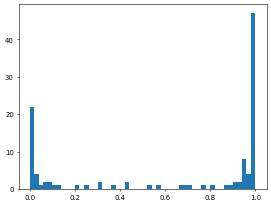

class_thr: 0.25


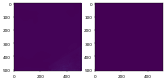

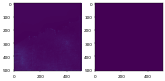

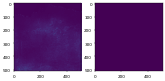

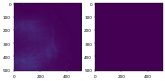

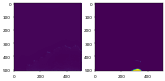

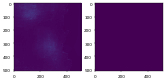

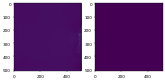

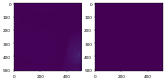

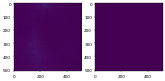

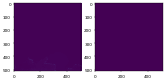

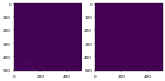

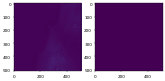

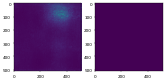

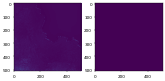

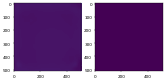

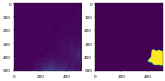

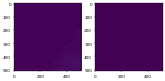

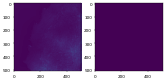

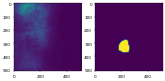

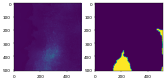

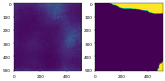

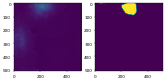

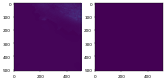

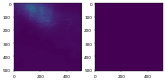

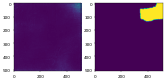

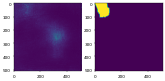

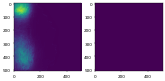

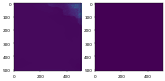

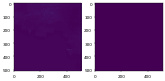

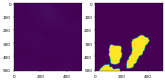

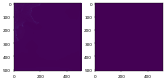

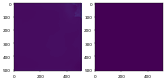

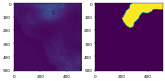

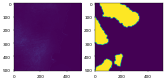

	 th: 0.1, fbeta: 0.4782144720698751
	 th: 0.15, fbeta: 0.4979807766191983
	 th: 0.2, fbeta: 0.49257242940696877
	 th: 0.25, fbeta: 0.4676833834860927
	 th: 0.3, fbeta: 0.42738351274271474
	 th: 0.35, fbeta: 0.3763781163427653
	 th: 0.4, fbeta: 0.31941281640742913
	 th: 0.45, fbeta: 0.2598191666876245
	 th: 0.5, fbeta: 0.20250131390875611
	 th: 0.55, fbeta: 0.15071223513615617
	 th: 0.6, fbeta: 0.10576933146738202
	 th: 0.65, fbeta: 0.06878607275441981
	 th: 0.7, fbeta: 0.0400249700304472
	 th: 0.75, fbeta: 0.019929831904104408
	 th: 0.8, fbeta: 0.007892654695277607
	 th: 0.85, fbeta: 0.0021391455264435527
	 th: 0.9, fbeta: 0.0003562538825520668
	 th: 0.95, fbeta: 3.370862784564508e-05
	 th: 1.0, fbeta: 0.0


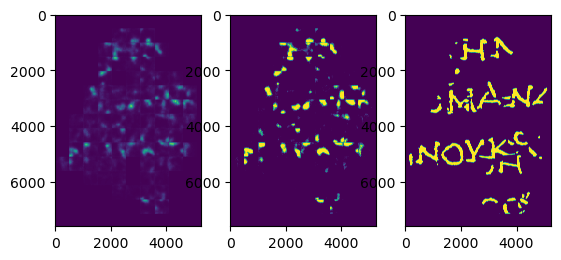

	 score:0.4980(th=0.150000), auc=0.863747, auc class=0.814011 ::: time:34.15s
surface_list: [27, 30, 33, 36]
slide pos:[0, 0]


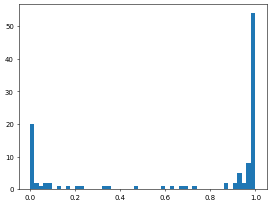

class_thr: 0.25


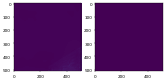

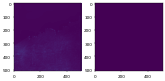

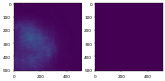

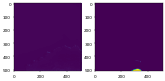

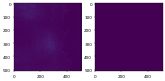

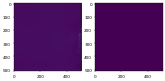

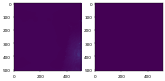

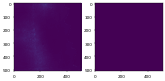

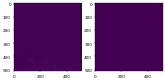

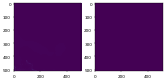

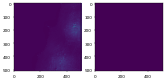

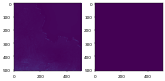

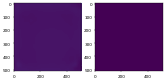

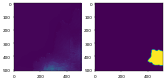

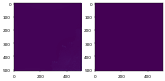

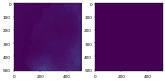

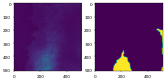

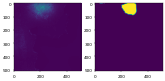

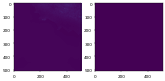

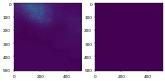

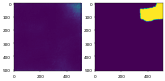

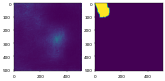

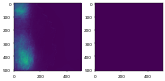

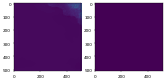

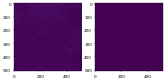

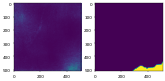

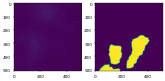

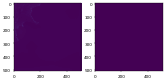

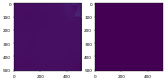

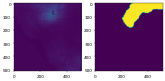

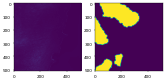

	 th: 0.1, fbeta: 0.507345636258437
	 th: 0.15, fbeta: 0.5221658100582713
	 th: 0.2, fbeta: 0.4986458351563878
	 th: 0.25, fbeta: 0.45640494504364887
	 th: 0.3, fbeta: 0.4026748826417595
	 th: 0.35, fbeta: 0.34380691566668237
	 th: 0.4, fbeta: 0.2850199133413011
	 th: 0.45, fbeta: 0.22936373066185747
	 th: 0.5, fbeta: 0.1785026365934391
	 th: 0.55, fbeta: 0.13296498357356423
	 th: 0.6, fbeta: 0.09277356485621015
	 th: 0.65, fbeta: 0.05948885135264726
	 th: 0.7, fbeta: 0.034696934032938886
	 th: 0.75, fbeta: 0.017897283057764127
	 th: 0.8, fbeta: 0.007996193594255439
	 th: 0.85, fbeta: 0.002799572748171209
	 th: 0.9, fbeta: 0.0006225095933706194
	 th: 0.95, fbeta: 4.173423894211201e-05
	 th: 1.0, fbeta: 0.0


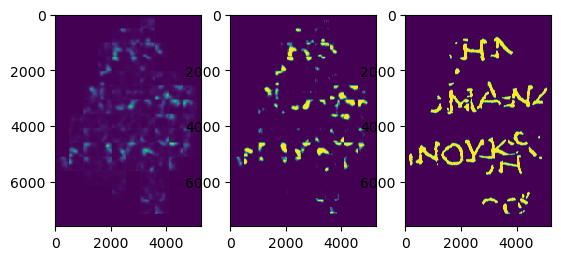

	 score:0.5222(th=0.150000), auc=0.863590, auc class=0.800498 ::: time:65.45s
surface_list: [25, 28, 31, 34]
slide pos:[0, 0]


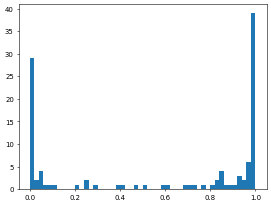

class_thr: 0.25


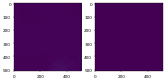

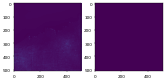

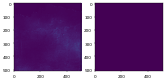

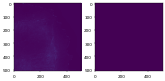

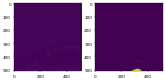

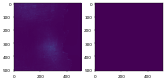

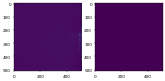

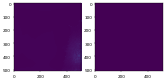

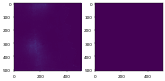

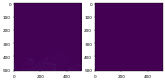

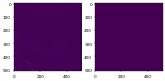

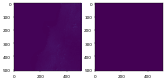

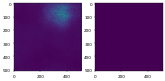

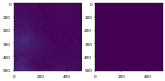

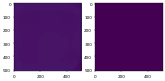

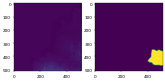

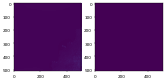

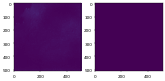

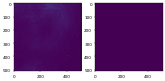

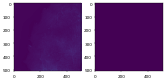

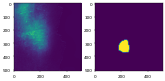

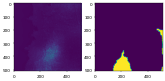

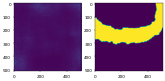

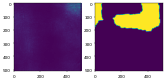

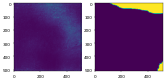

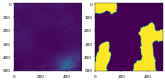

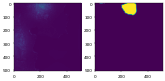

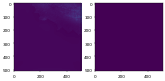

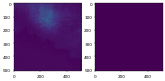

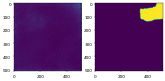

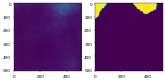

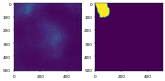

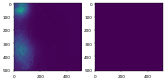

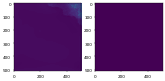

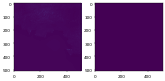

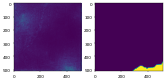

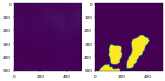

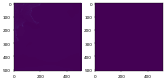

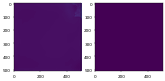

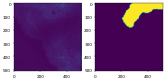

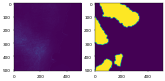

	 th: 0.1, fbeta: 0.4669530914810861
	 th: 0.15, fbeta: 0.4821819818600002
	 th: 0.2, fbeta: 0.47217901278308777
	 th: 0.25, fbeta: 0.4430124173177888
	 th: 0.3, fbeta: 0.4016666879043625
	 th: 0.35, fbeta: 0.35360545195070636
	 th: 0.4, fbeta: 0.3018439129256301
	 th: 0.45, fbeta: 0.249123503551122
	 th: 0.5, fbeta: 0.19662019259474608
	 th: 0.55, fbeta: 0.14780481051869618
	 th: 0.6, fbeta: 0.10454226218717015
	 th: 0.65, fbeta: 0.06948780615515873
	 th: 0.7, fbeta: 0.042867642359876904
	 th: 0.75, fbeta: 0.024278723426726233
	 th: 0.8, fbeta: 0.011558938555831335
	 th: 0.85, fbeta: 0.003444620385620919
	 th: 0.9, fbeta: 0.0004348561281495031
	 th: 0.95, fbeta: 1.6051528343149827e-06
	 th: 1.0, fbeta: 0.0


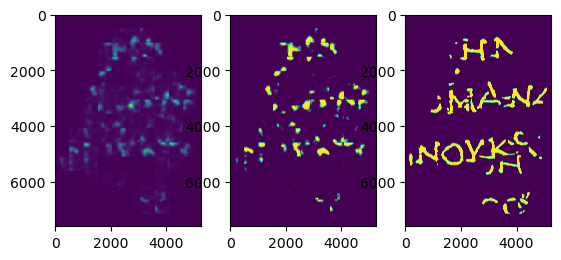

	 score:0.4822(th=0.150000), auc=0.829040, auc class=0.815434 ::: time:98.65s
	 th: 0.1, fbeta: 0.35131790276108416
	 th: 0.15, fbeta: 0.4121867857650864
	 th: 0.2, fbeta: 0.45350705426708965
	 th: 0.25, fbeta: 0.4812804020021431
	 th: 0.3, fbeta: 0.4994884565827462
	 th: 0.35, fbeta: 0.5107347863302344
	 th: 0.4, fbeta: 0.517144966665589
	 th: 0.45, fbeta: 0.519320352758643
	 th: 0.5, fbeta: 0.518126449670382
	 th: 0.55, fbeta: 0.514092278869907
	 th: 0.6, fbeta: 0.5076189584940225
	 th: 0.65, fbeta: 0.49833534641036464
	 th: 0.7, fbeta: 0.4863370445108024
	 th: 0.75, fbeta: 0.4722150293540105
	 th: 0.8, fbeta: 0.4560598853580943
	 th: 0.85, fbeta: 0.43821717750224504
	 th: 0.9, fbeta: 0.41881228888743327
	 th: 0.95, fbeta: 0.3982545001865155
	 th: 1.0, fbeta: 0.37651795076574307


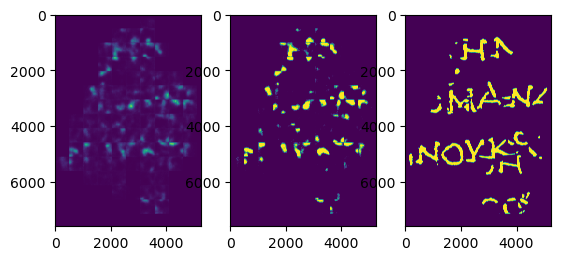

[fold0] slice ave score:0.5193(th=0.450000), auc=0.868434
-- fold1 slide inference start --
surface_list: [26, 29, 32, 35]
slide pos:[0, 0]


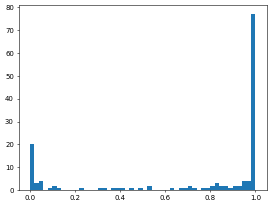

class_thr: 0.25


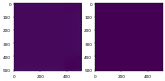

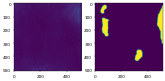

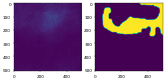

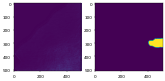

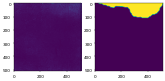

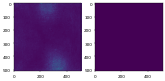

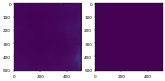

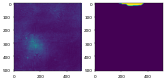

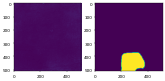

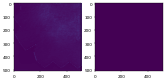

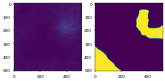

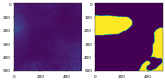

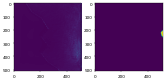

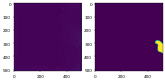

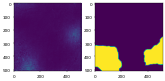

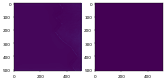

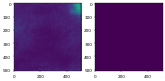

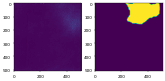

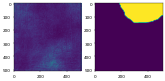

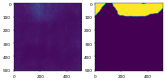

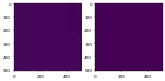

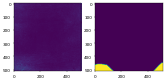

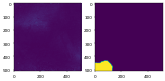

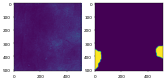

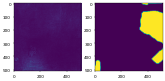

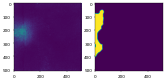

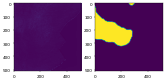

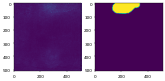

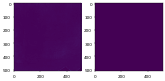

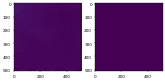

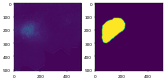

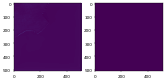

	 th: 0.1, fbeta: 0.4972246000598844
	 th: 0.15, fbeta: 0.498074252619202
	 th: 0.2, fbeta: 0.4690588555414391
	 th: 0.25, fbeta: 0.4280210577509502
	 th: 0.3, fbeta: 0.3820141707644623
	 th: 0.35, fbeta: 0.3353881160380094
	 th: 0.4, fbeta: 0.2883879497424589
	 th: 0.45, fbeta: 0.24357685796043602
	 th: 0.5, fbeta: 0.2034523943277462
	 th: 0.55, fbeta: 0.16828199610793843
	 th: 0.6, fbeta: 0.1376518311479997
	 th: 0.65, fbeta: 0.1112628347243582
	 th: 0.7, fbeta: 0.08831806759575019
	 th: 0.75, fbeta: 0.06760531135468072
	 th: 0.8, fbeta: 0.049790011303876426
	 th: 0.85, fbeta: 0.03370768416784861
	 th: 0.9, fbeta: 0.017640110212202003
	 th: 0.95, fbeta: 0.003041234360855333
	 th: 1.0, fbeta: 0.0


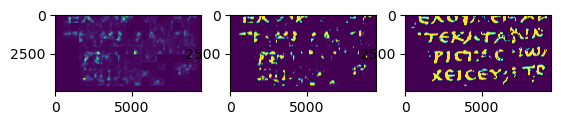

	 score:0.4981(th=0.150000), auc=0.800228, auc class=0.829073 ::: time:144.85s
surface_list: [27, 30, 33, 36]
slide pos:[0, 0]


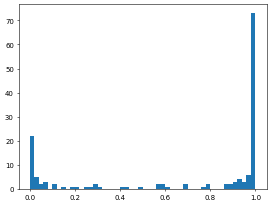

class_thr: 0.25


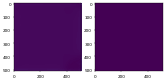

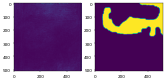

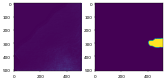

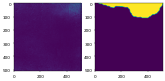

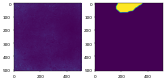

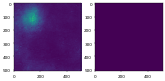

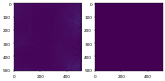

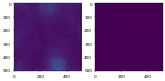

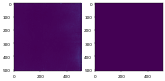

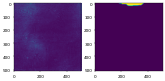

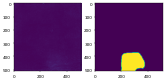

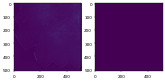

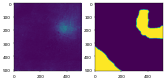

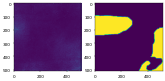

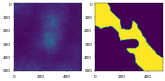

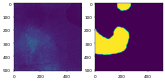

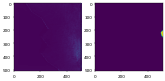

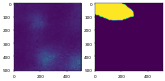

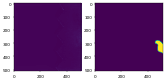

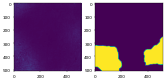

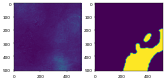

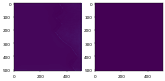

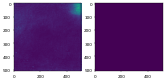

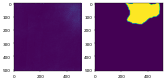

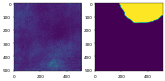

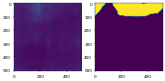

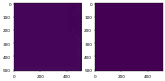

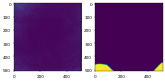

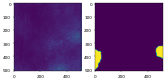

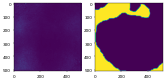

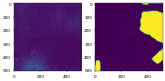

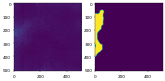

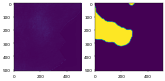

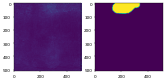

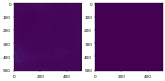

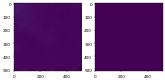

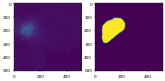

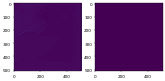

	 th: 0.1, fbeta: 0.4979724612111393
	 th: 0.15, fbeta: 0.4911934953946907
	 th: 0.2, fbeta: 0.4587935073908078
	 th: 0.25, fbeta: 0.4168229941655931
	 th: 0.3, fbeta: 0.37371634815636856
	 th: 0.35, fbeta: 0.3319564350031286
	 th: 0.4, fbeta: 0.2919230187407938
	 th: 0.45, fbeta: 0.25352726082733085
	 th: 0.5, fbeta: 0.21632926971264854
	 th: 0.55, fbeta: 0.1812260639658739
	 th: 0.6, fbeta: 0.1502754178315044
	 th: 0.65, fbeta: 0.123491605949065
	 th: 0.7, fbeta: 0.10056425037311274
	 th: 0.75, fbeta: 0.07989634876633014
	 th: 0.8, fbeta: 0.05975950466098067
	 th: 0.85, fbeta: 0.03877325329008992
	 th: 0.9, fbeta: 0.01901241721258477
	 th: 0.95, fbeta: 0.0037605217967811846
	 th: 1.0, fbeta: 0.0


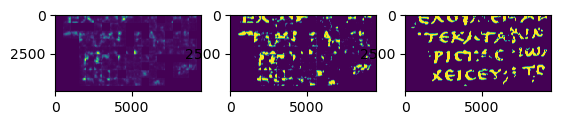

	 score:0.4980(th=0.100000), auc=0.790530, auc class=0.833584 ::: time:177.24s
surface_list: [25, 28, 31, 34]
slide pos:[0, 0]


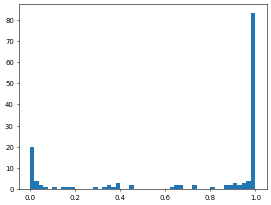

class_thr: 0.25


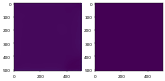

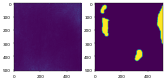

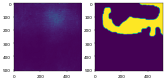

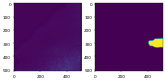

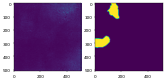

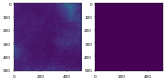

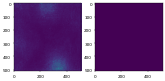

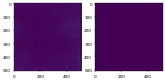

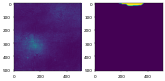

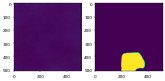

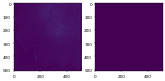

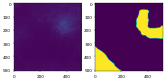

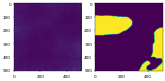

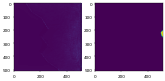

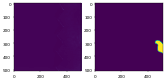

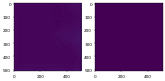

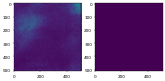

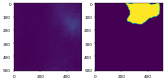

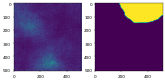

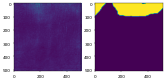

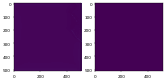

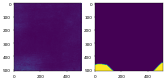

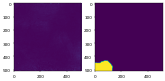

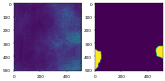

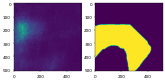

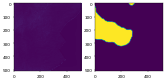

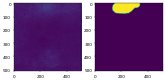

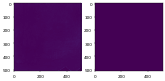

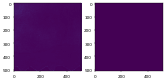

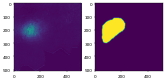

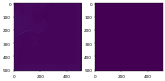

	 th: 0.1, fbeta: 0.48226835999315343
	 th: 0.15, fbeta: 0.4902819616209221
	 th: 0.2, fbeta: 0.4679652397780732
	 th: 0.25, fbeta: 0.4319753229273111
	 th: 0.3, fbeta: 0.38975292212599244
	 th: 0.35, fbeta: 0.34594501449887644
	 th: 0.4, fbeta: 0.30289507424180473
	 th: 0.45, fbeta: 0.2612743577674127
	 th: 0.5, fbeta: 0.2209073876202812
	 th: 0.55, fbeta: 0.18301361906511035
	 th: 0.6, fbeta: 0.14800533452120757
	 th: 0.65, fbeta: 0.11788206668484204
	 th: 0.7, fbeta: 0.09317642892238949
	 th: 0.75, fbeta: 0.07251382121364314
	 th: 0.8, fbeta: 0.05437596030254132
	 th: 0.85, fbeta: 0.03650781206103853
	 th: 0.9, fbeta: 0.018631774106401756
	 th: 0.95, fbeta: 0.0037485714234663597
	 th: 1.0, fbeta: 0.0


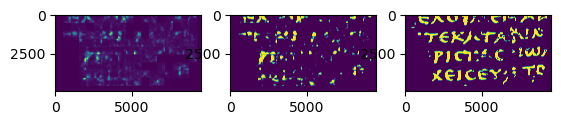

	 score:0.4903(th=0.150000), auc=0.797473, auc class=0.852130 ::: time:207.70s
	 th: 0.1, fbeta: 0.36720519567026993
	 th: 0.15, fbeta: 0.42595897814454026
	 th: 0.2, fbeta: 0.4671650123222475
	 th: 0.25, fbeta: 0.4938399692261106
	 th: 0.3, fbeta: 0.5085896096987543
	 th: 0.35, fbeta: 0.5144224521264947
	 th: 0.4, fbeta: 0.5138105846964773
	 th: 0.45, fbeta: 0.5090336998009746
	 th: 0.5, fbeta: 0.5012349541495863
	 th: 0.55, fbeta: 0.4911126046966653
	 th: 0.6, fbeta: 0.47908463929474715
	 th: 0.65, fbeta: 0.4656596358847712
	 th: 0.7, fbeta: 0.45082993664753074
	 th: 0.75, fbeta: 0.43494569943359634
	 th: 0.8, fbeta: 0.4183438668863012
	 th: 0.85, fbeta: 0.4011870866136065
	 th: 0.9, fbeta: 0.38352927375041257
	 th: 0.95, fbeta: 0.36545265640191776
	 th: 1.0, fbeta: 0.3471879803661682


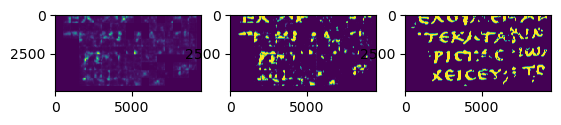

[fold1] slice ave score:0.5144(th=0.350000), auc=0.811204
-- fold2 slide inference start --
surface_list: [26, 29, 32, 35]
slide pos:[0, 0]


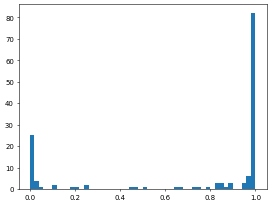

class_thr: 0.25


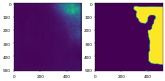

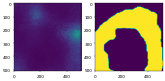

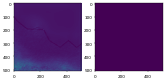

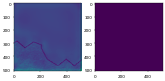

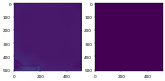

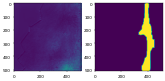

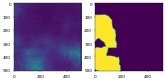

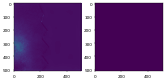

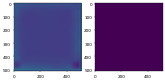

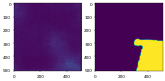

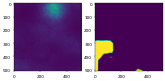

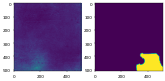

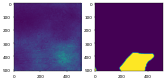

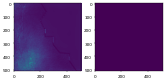

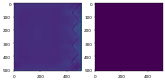

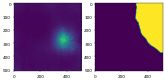

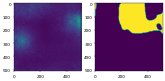

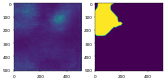

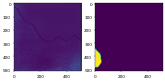

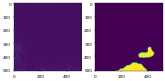

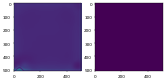

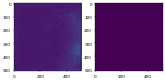

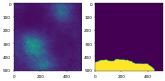

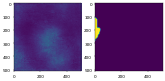

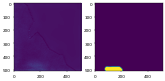

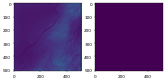

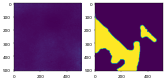

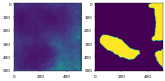

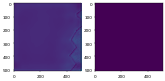

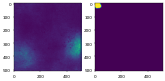

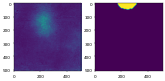

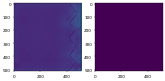

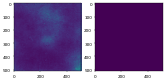

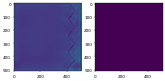

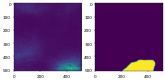

	 th: 0.1, fbeta: 0.4408239240416436
	 th: 0.15, fbeta: 0.4547052230557187
	 th: 0.2, fbeta: 0.45013230596005455
	 th: 0.25, fbeta: 0.4358369750041719
	 th: 0.3, fbeta: 0.41512456003244014
	 th: 0.35, fbeta: 0.3883105980528213
	 th: 0.4, fbeta: 0.3550638417584504
	 th: 0.45, fbeta: 0.3157702608246637
	 th: 0.5, fbeta: 0.2713507115443494
	 th: 0.55, fbeta: 0.22416666411966227
	 th: 0.6, fbeta: 0.17765685827795044
	 th: 0.65, fbeta: 0.1314631054692657
	 th: 0.7, fbeta: 0.08850233426979975
	 th: 0.75, fbeta: 0.05053176729344855
	 th: 0.8, fbeta: 0.021516835647471394
	 th: 0.85, fbeta: 0.00573791241426632
	 th: 0.9, fbeta: 0.000443977837739491
	 th: 0.95, fbeta: 0.0
	 th: 1.0, fbeta: 0.0


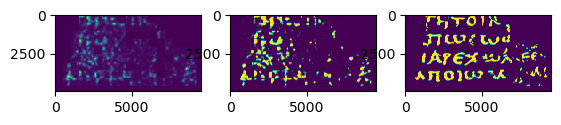

	 score:0.4547(th=0.150000), auc=0.785860, auc class=0.865079 ::: time:257.77s
surface_list: [27, 30, 33, 36]
slide pos:[0, 0]


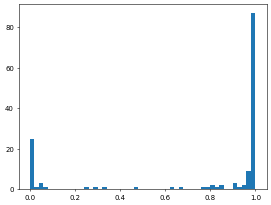

class_thr: 0.25


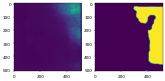

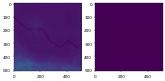

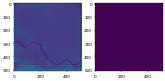

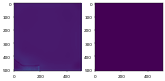

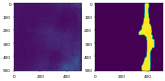

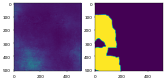

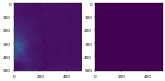

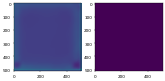

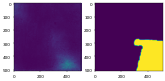

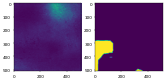

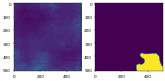

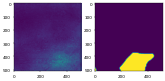

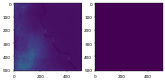

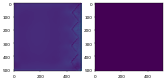

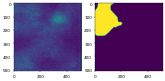

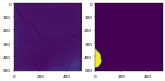

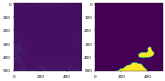

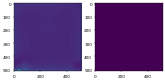

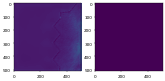

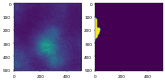

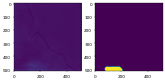

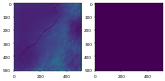

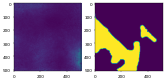

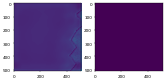

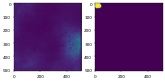

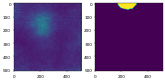

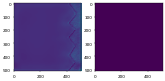

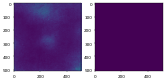

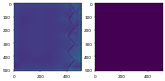

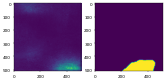

	 th: 0.1, fbeta: 0.4369757226425782
	 th: 0.15, fbeta: 0.4603353236143605
	 th: 0.2, fbeta: 0.4665699857942444
	 th: 0.25, fbeta: 0.4586649894355411
	 th: 0.3, fbeta: 0.4382775289039441
	 th: 0.35, fbeta: 0.4064591411400471
	 th: 0.4, fbeta: 0.3660725542733557
	 th: 0.45, fbeta: 0.3187961313686327
	 th: 0.5, fbeta: 0.26511310184818165
	 th: 0.55, fbeta: 0.20677196666466507
	 th: 0.6, fbeta: 0.1497061247236347
	 th: 0.65, fbeta: 0.10050222931425737
	 th: 0.7, fbeta: 0.06152376973799257
	 th: 0.75, fbeta: 0.033413549039421814
	 th: 0.8, fbeta: 0.014968453710791566
	 th: 0.85, fbeta: 0.004536412826823535
	 th: 0.9, fbeta: 0.00020282659726942486
	 th: 0.95, fbeta: 0.0
	 th: 1.0, fbeta: 0.0


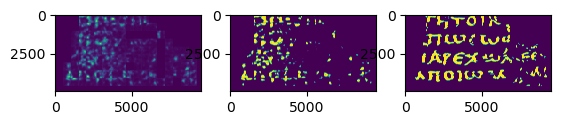

	 score:0.4666(th=0.200000), auc=0.807035, auc class=0.867586 ::: time:287.76s
surface_list: [25, 28, 31, 34]
slide pos:[0, 0]


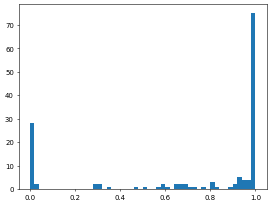

class_thr: 0.25


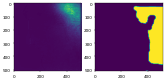

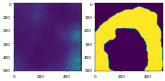

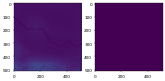

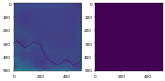

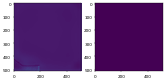

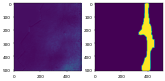

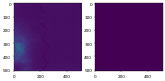

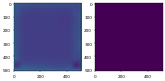

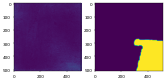

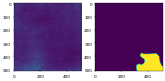

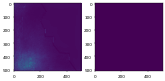

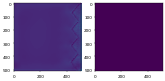

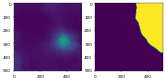

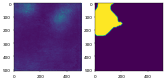

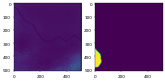

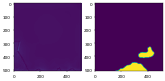

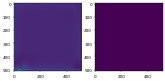

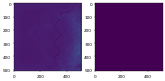

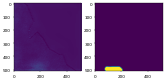

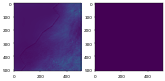

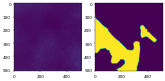

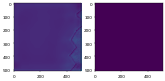

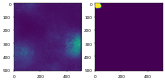

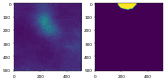

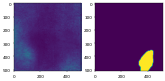

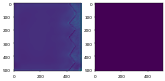

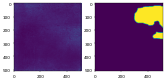

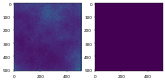

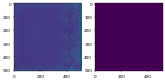

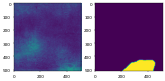

	 th: 0.1, fbeta: 0.44716461748437875
	 th: 0.15, fbeta: 0.4618825542459406
	 th: 0.2, fbeta: 0.45756964470163514
	 th: 0.25, fbeta: 0.4407229669057548
	 th: 0.3, fbeta: 0.4151705993957268
	 th: 0.35, fbeta: 0.3829387941744313
	 th: 0.4, fbeta: 0.34415379455258854
	 th: 0.45, fbeta: 0.2999836294333678
	 th: 0.5, fbeta: 0.25277492448002326
	 th: 0.55, fbeta: 0.20528883883577745
	 th: 0.6, fbeta: 0.16019411947183376
	 th: 0.65, fbeta: 0.11851224097222847
	 th: 0.7, fbeta: 0.08286126087978332
	 th: 0.75, fbeta: 0.05181766902278064
	 th: 0.8, fbeta: 0.02622638832325626
	 th: 0.85, fbeta: 0.009324381672144921
	 th: 0.9, fbeta: 0.0011001597045567182
	 th: 0.95, fbeta: 1.3062826744160158e-05
	 th: 1.0, fbeta: 0.0


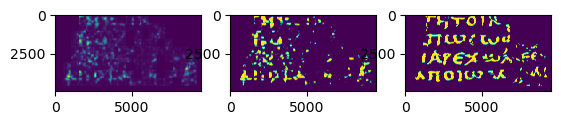

	 score:0.4619(th=0.150000), auc=0.793311, auc class=0.863826 ::: time:317.92s
	 th: 0.1, fbeta: 0.33980751248024266
	 th: 0.15, fbeta: 0.38452267271057644
	 th: 0.2, fbeta: 0.4109824304854485
	 th: 0.25, fbeta: 0.4298886458320423
	 th: 0.3, fbeta: 0.4443985899116115
	 th: 0.35, fbeta: 0.45562409471260995
	 th: 0.4, fbeta: 0.46399962048872573
	 th: 0.45, fbeta: 0.4694316194555216
	 th: 0.5, fbeta: 0.47185034884762467
	 th: 0.55, fbeta: 0.4718973034290136
	 th: 0.6, fbeta: 0.46971203422687957
	 th: 0.65, fbeta: 0.46571746456289526
	 th: 0.7, fbeta: 0.46052089261016155
	 th: 0.75, fbeta: 0.4539549559702869
	 th: 0.8, fbeta: 0.4463868706103618
	 th: 0.85, fbeta: 0.4378628959143479
	 th: 0.9, fbeta: 0.428575580563498
	 th: 0.95, fbeta: 0.41838202608902464
	 th: 1.0, fbeta: 0.40733033984194267


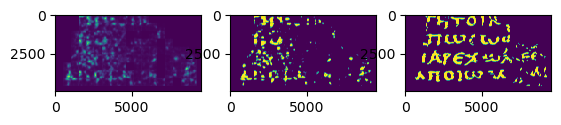

[fold2] slice ave score:0.4719(th=0.550000), auc=0.808553
-- fold3 slide inference start --
surface_list: [26, 29, 32, 35]
slide pos:[0, 0]


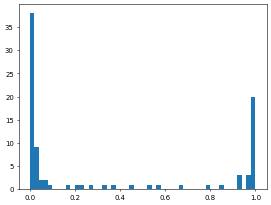

class_thr: 0.25


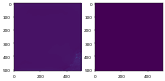

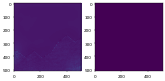

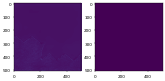

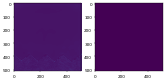

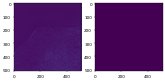

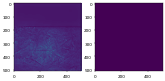

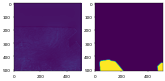

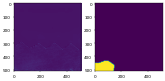

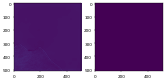

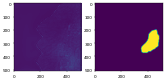

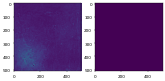

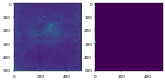

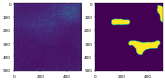

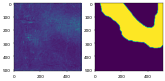

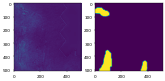

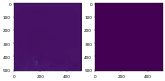

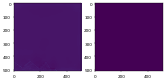

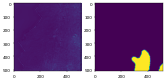

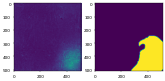

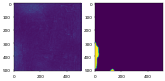

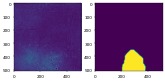

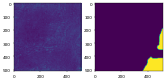

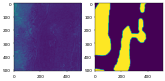

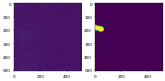

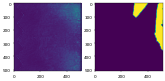

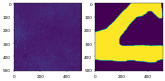

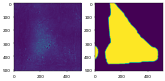

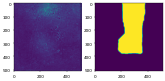

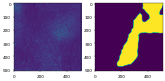

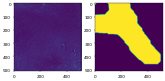

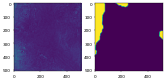

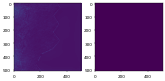

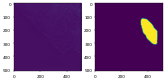

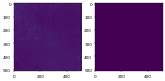

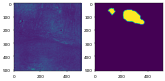

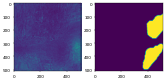

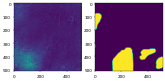

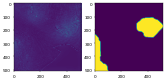

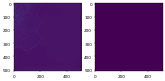

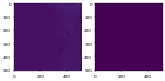

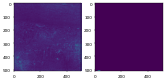

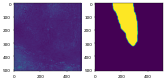

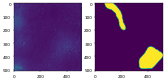

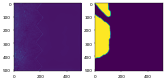

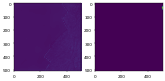

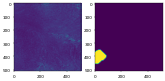

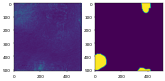

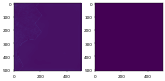

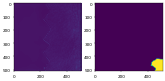

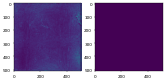

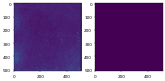

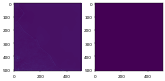

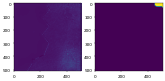

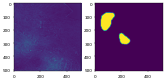

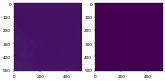

	 th: 0.1, fbeta: 0.3410634599718196
	 th: 0.15, fbeta: 0.4010191598060387
	 th: 0.2, fbeta: 0.4108268456191096
	 th: 0.25, fbeta: 0.3940778277723157
	 th: 0.3, fbeta: 0.3601182598411045
	 th: 0.35, fbeta: 0.31611577982949735
	 th: 0.4, fbeta: 0.2682321811413792
	 th: 0.45, fbeta: 0.22228608225588517
	 th: 0.5, fbeta: 0.1807666086905183
	 th: 0.55, fbeta: 0.14297859918161024
	 th: 0.6, fbeta: 0.10724708057839517
	 th: 0.65, fbeta: 0.0744558845783666
	 th: 0.7, fbeta: 0.0464171568423331
	 th: 0.75, fbeta: 0.025371841091281537
	 th: 0.8, fbeta: 0.01253265247833073
	 th: 0.85, fbeta: 0.007196302258648657
	 th: 0.9, fbeta: 0.004595677878584514
	 th: 0.95, fbeta: 0.0012789751771916642
	 th: 1.0, fbeta: 0.0


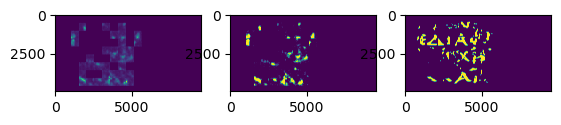

	 score:0.4108(th=0.200000), auc=0.742735, auc class=0.844286 ::: time:362.39s
surface_list: [27, 30, 33, 36]
slide pos:[0, 0]


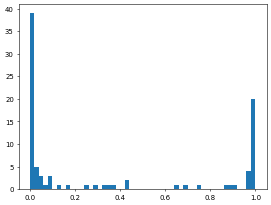

class_thr: 0.25


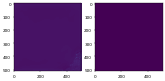

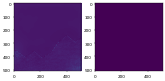

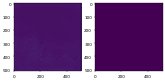

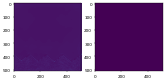

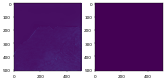

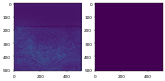

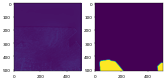

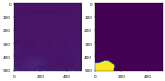

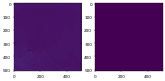

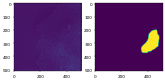

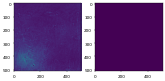

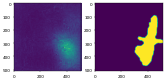

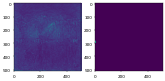

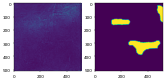

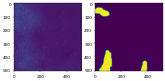

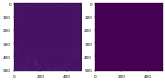

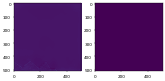

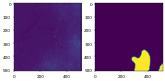

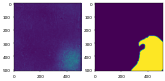

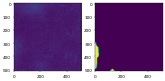

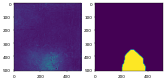

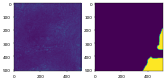

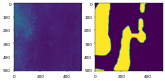

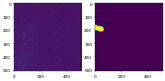

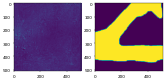

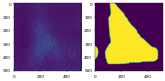

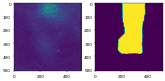

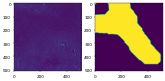

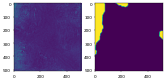

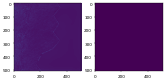

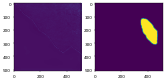

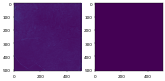

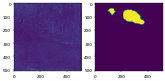

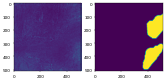

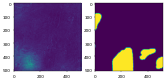

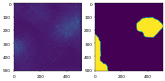

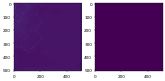

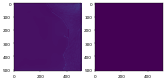

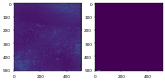

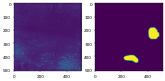

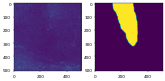

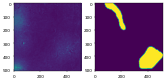

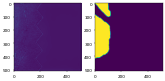

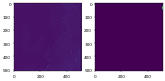

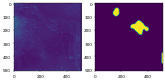

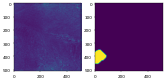

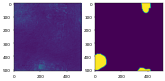

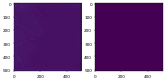

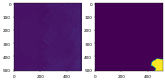

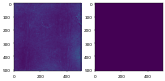

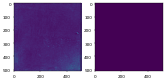

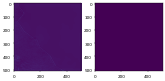

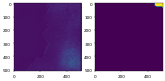

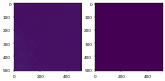

	 th: 0.1, fbeta: 0.3463187439807886
	 th: 0.15, fbeta: 0.39601847709829036
	 th: 0.2, fbeta: 0.39293266785981007
	 th: 0.25, fbeta: 0.36642264525831814
	 th: 0.3, fbeta: 0.32916248269858395
	 th: 0.35, fbeta: 0.2863225999438017
	 th: 0.4, fbeta: 0.24152054904286818
	 th: 0.45, fbeta: 0.19932170249130404
	 th: 0.5, fbeta: 0.1608660034148807
	 th: 0.55, fbeta: 0.12748083721501313
	 th: 0.6, fbeta: 0.0994844210555325
	 th: 0.65, fbeta: 0.0760567031068967
	 th: 0.7, fbeta: 0.055647203970668184
	 th: 0.75, fbeta: 0.039690092509060734
	 th: 0.8, fbeta: 0.028271431488996957
	 th: 0.85, fbeta: 0.020226202970313717
	 th: 0.9, fbeta: 0.013719254056423047
	 th: 0.95, fbeta: 0.0077336899439257424
	 th: 1.0, fbeta: 0.0


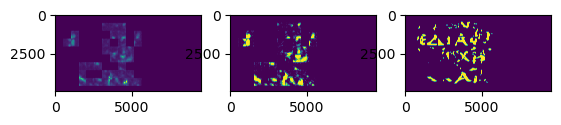

	 score:0.3960(th=0.150000), auc=0.764131, auc class=0.829286 ::: time:388.64s
surface_list: [25, 28, 31, 34]
slide pos:[0, 0]


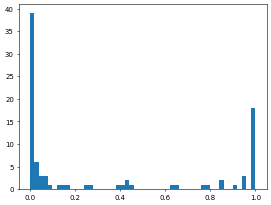

class_thr: 0.25


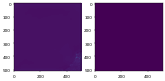

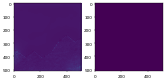

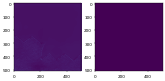

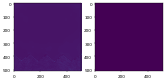

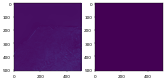

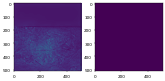

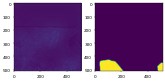

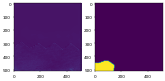

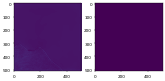

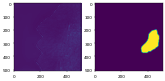

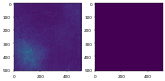

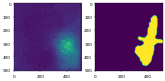

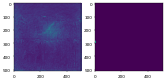

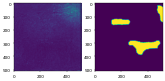

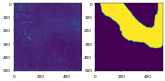

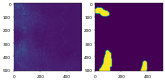

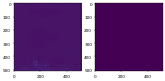

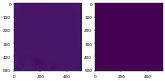

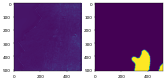

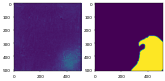

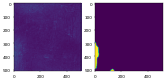

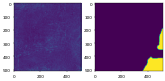

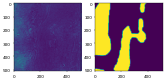

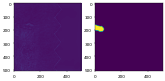

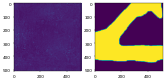

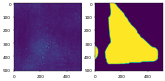

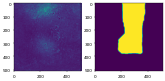

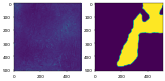

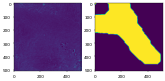

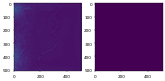

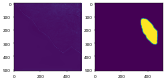

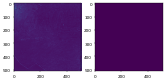

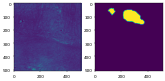

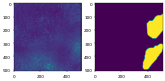

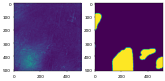

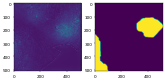

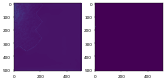

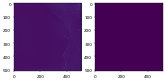

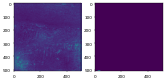

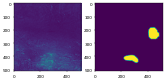

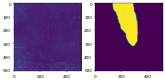

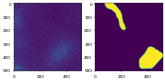

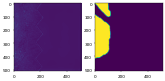

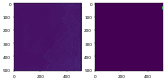

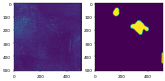

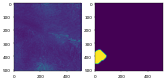

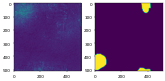

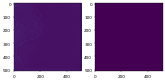

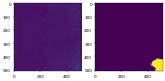

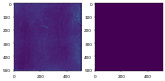

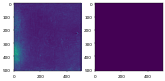

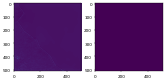

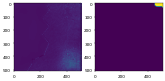

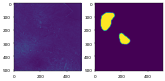

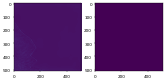

	 th: 0.1, fbeta: 0.3437485826675626
	 th: 0.15, fbeta: 0.39350762040401277
	 th: 0.2, fbeta: 0.39374685561319767
	 th: 0.25, fbeta: 0.36635568788802747
	 th: 0.3, fbeta: 0.31821322626873677
	 th: 0.35, fbeta: 0.2589543225635203
	 th: 0.4, fbeta: 0.20473560374613758
	 th: 0.45, fbeta: 0.16006671389803118
	 th: 0.5, fbeta: 0.12514953035751256
	 th: 0.55, fbeta: 0.09603671163274044
	 th: 0.6, fbeta: 0.07110491660107793
	 th: 0.65, fbeta: 0.05028475383466797
	 th: 0.7, fbeta: 0.03417894968158504
	 th: 0.75, fbeta: 0.02172293122044733
	 th: 0.8, fbeta: 0.011400714828095355
	 th: 0.85, fbeta: 0.0041719699320125645
	 th: 0.9, fbeta: 0.0011664502350382992
	 th: 0.95, fbeta: 1.7561989313880773e-05
	 th: 1.0, fbeta: 0.0


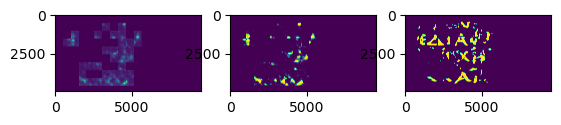

	 score:0.3937(th=0.200000), auc=0.743697, auc class=0.828571 ::: time:415.63s
	 th: 0.1, fbeta: 0.22898888974534215
	 th: 0.15, fbeta: 0.2441327120698949
	 th: 0.2, fbeta: 0.27784336189853
	 th: 0.25, fbeta: 0.31662022977455645
	 th: 0.3, fbeta: 0.3522029154864339
	 th: 0.35, fbeta: 0.38089527579714894
	 th: 0.4, fbeta: 0.4005411530193646
	 th: 0.45, fbeta: 0.4117506647991235
	 th: 0.5, fbeta: 0.4163652940848162
	 th: 0.55, fbeta: 0.41646774178960894
	 th: 0.6, fbeta: 0.4131326246397078
	 th: 0.65, fbeta: 0.4062425595226799
	 th: 0.7, fbeta: 0.3965552387671672
	 th: 0.75, fbeta: 0.38451115462083535
	 th: 0.8, fbeta: 0.37101341182897934
	 th: 0.85, fbeta: 0.3562096398001765
	 th: 0.9, fbeta: 0.3400823558597647
	 th: 0.95, fbeta: 0.3230010367148904
	 th: 1.0, fbeta: 0.3054294517040259


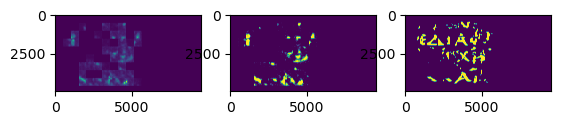

[fold3] slice ave score:0.4165(th=0.550000), auc=0.772643
-- fold4 slide inference start --
surface_list: [26, 29, 32, 35]
slide pos:[0, 0]


In [116]:
%%time
slice_ave_score_list, slice_ave_auc_list, slice_ave_score_threshold_list = slide_inference(CFG)
for fold in CFG["folds"]:
    print(f"fold[{fold}] slice ave score:{slice_ave_score_list[fold]:.4f}(th={slice_ave_score_threshold_list[fold]:3f}), auc={slice_ave_auc_list[fold]:4f}")


In [ ]:
%%time
pred_flatten_list = []
mask_flatten_list = []
for fold in [0,1,2,3,4]:
    pred_path = os.path.join(OUTPUT_DIR, "imgs", f"fold{fold}_average_slice555_valid_pred_img.png")
    mask_path = os.path.join(OUTPUT_DIR, "imgs", f"fold{fold}_average_slice555_valid_targets_img.png")
    print(pred_path)
    pred_img = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)
    mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    print(pred_img.shape)
    print(mask_img.shape)
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(pred_img)
    plt.subplot(1, 2, 2)
    plt.imshow(mask_img)
    plt.show()
    pred_flatten_list.extend(pred_img.flatten())
    mask_flatten_list.extend(mask_img.flatten())

In [ ]:
mask_flatten_list = np.array(mask_flatten_list)/255.
mask = np.array(mask_flatten_list).astype(int)
pred = np.array(pred_flatten_list)/255.

plt.figure()
plt.subplot(1, 2, 1)
plt.hist(pred, bins=100)
plt.subplot(1, 2, 2)
plt.hist(mask)
plt.show()

for th in np.array(range(10, 100+1, 5)) / 100:
    dice = fbeta_numpy(mask, (pred >= th).astype(int), beta=0.5)
    print(f"th={th:.2f}, dice={dice:.4f}")